# Programming Exercise 3: Multi-class Classification and Neural Networks

## Introduction
In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits.

## 1. Mutil-class Classification
For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you've learned can be used for this classification task.

In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import minimize
from scipy.io import loadmat  # to load .mat file
from IPython.display import clear_output  # clear the output of the cell

%matplotlib inline

### 1.1. Dataset
You are given a data set in `data/ex3/ex3data1.mat` that contains 5000 training examples of handwritten digits. The `.mat` format means that that the data has been saved in a native MATLAB/Octave matrix format, instead of text (ASCII) format like a csv-file.

There are 5000 training examples in `data/ex3/ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is "unrolled" into a 400-dimensional vector. Each of these training examples becomes a single a row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

$$ X = \left[\begin{array}{ccc} \text{——} (x^{(1)})^T \text{——} \\ \text{——} (x^{(2)})^T \text{——} \\ \vdots \\ \text{——} (x^{(m)})^T \text{——} \end{array}\right] $$

The second part of the training set is a 5000-dimensional vector $y$ that contains labels for the training set. For some programming languages don't have zero index, the digit zero has been mapped to the value ten. Therefore, a "0" digit is labeled as "10", while the digits "1" to "9" are labeled as "1" to "9" in their natural order.

### 1.2. Visualizing the data
You will begin by visualizing a subset of the training set. In part one, the code randomly selects 100 rows from `X` and passes those row to the `displayData` function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together.

In [2]:
# Loading and Visualizing Data
data = loadmat('data/ex3/ex3data1.mat')  # data is a 'dict' object
# Get X and y from dict data
X = data['X']  # (5000, 400) ndarray
y = data['y']  # (5000, 1) ndarray

m = X.shape[0] # the number of training examples
num_labels = 10 # 10 labels, from 1 to 10

# Randomly select 100 data points to display
rand_indices = np.random.randint(0, m, 100)

In [3]:
def displayData(X, example_width=None):
    """
    `displayData(X, example_width)` displays 2D data stored in X in a nice
    grid.
    """
    
    if (example_width == None):
        example_width = int(np.sqrt(X.shape[1]))
        
    # Compute the number of images, the pixels of each image
    m, pixels = X.shape
    
    # Compute the height of each image
    w = example_width
    h = int(pixels / w)
    
    # Compute nubmer of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))
    # print(display_rows, display_cols)
    
    # The padding between images
    h_padding = -np.ones((1, (w+1)*display_cols+1))
    v_padding = -np.ones((h, 1))
    
    # Setup blank display
    display_array = h_padding
    row_images = v_padding
    
    # Rearange the data
    # Note that the scan order used by reshape in NumPy defaults to
    # the ‘C’ order, whereas MATLAB uses the Fortran order. We can do
    # transpose to make the transform.
    # https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html
    stacked_images = X.reshape(m * h, w)
    split_stacked_images = np.array(np.vsplit(stacked_images, range(h, m*h, h)))
    # print(split_stacked_images.shape)
    
    for i in range(1, display_rows*display_cols+1):
        
        # if can't be displaed as a exact square
        if i > m:
            single_image = -np.ones((h, w)) # blank
        else:
            single_image = split_stacked_images[i-1].T # digit image
        
        if (i % display_cols) == 0:
            # print("i = " + str(i), "display_cols = " + str(display_cols))
            row_images = np.hstack((row_images, single_image))
            row_images = np.hstack((row_images, v_padding))
            display_array = np.vstack((display_array, row_images))
            display_array = np.vstack((display_array, h_padding))
            row_images = v_padding # clear row_images to v_padding
        else:
            row_images = np.hstack((row_images, single_image))
            row_images = np.hstack((row_images, v_padding))
    
    # print(display_array.shape)
    
    # Display image
    plt.imshow(display_array, cmap='gray')
    plt.axis("off")
    plt.title("Examples from the dataset")
    plt.show()

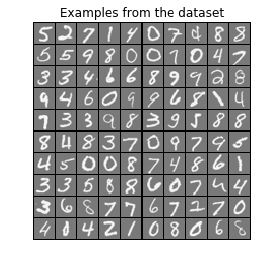

[[ 5  2  7  1  4 10  7  4  8  8]
 [ 5  5  9  8 10 10  7 10  4  7]
 [ 3  3  4  6  6  8  9  9  2  8]
 [ 9  4  6 10  9  9  6  8  1  4]
 [ 7  3  3  9  8  3  9  5  8  8]
 [ 8  4  8  3  7 10  9  7  9  5]
 [ 4  5 10 10  8  7  4  8  6  1]
 [ 3  3  5  8  8  6 10  7  4  4]
 [ 3  6  8  7  7  6  7  2  7 10]
 [ 4 10  4  2  1 10  8 10  6  8]]


In [4]:
# Plot examples fromt the dataset
displayData(X[rand_indices])
# Display the labels of the examples. "10" denotes "0"
print(y[rand_indices].reshape(10, 10))

### 1.3. Vectorizing Logistic Regression
You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that dose not employ any `for` loops. You can use your code in the last exercise as a starting point for this exercise.

#### 1.3.1. Vectorizing the cost function
We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m [-y^{(i)} \log(h_{\theta}(x^{(i)})) - (1-y^{(i)}) \log (1-h_{\theta}(x^{(i)}))] $$

To compute each element in the summation, we have to compute $h_{\theta}(x^{(i)})$ for every example $i$, where $h_{\theta}(x^{(i)}) = g(\theta^T x^{(i)})$ and $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define $X$ and $\theta$ as
$$ X = \left[\begin{array}{ccc} \text{——} (x^{(1)})^T \text{——} \\ \text{——} (x^{(2)})^T \text{——} \\ \vdots \\ \text{——} (x^{(m)})^T \text{——} \end{array}\right] \quad \text{and} \quad
\theta = \left[\begin{array}{c}\theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{array}\right] $$

Then, by computing the matrix product $X\theta$, we have
$$ X\theta = \left[\begin{array}{ccc} \text{——} (x^{(1)})^T \theta \text{——} \\ \text{——} (x^{(2)})^T \theta \text{——} \\ \vdots \\ \text{——} (x^{(m)})^T \theta \text{——} \end{array}\right]
= \left[\begin{array}{ccc} \text{——} \theta^T(x^{(1)}) \text{——} \\ \text{——} \theta^T(x^{(2)}) \text{——} \\ \vdots \\ \text{——} \theta^T(x^{(m)}) \text{——} \end{array}\right] $$

In the last equality, we used the fact that $a^Tb = b^Ta$ if $a$ and $b$ are vectors. This allows us to compute the products $\theta^T x^{(i)}$ for all our examples $i$ in one line of code.

Your job is to write the unregularized cost function `lrCostFunctioin`. Your implementation should use the strategy we presented above to calculate $\theta^T x^{(i)}$. You should also use a vectorized approach for the rest of the cost function. A fully vectorized version of `lrCostFunction` should not contain any loops.

#### 1.3.2. Vectorizing the gradient
Recall that the gradient of the (unregularized) logistic regression cost is a vector where the $j^\text{th}$ element is defined as
$$ \frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m ((h_{\theta}(x^{(i)}) - y^{(i)}) x_j^{(i)}) $$

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$,
$$ \left[\begin{array}{c} \frac{\partial J}{\partial \theta_0} \\ \frac{\partial J}{\partial \theta_1} \\ \frac{\partial J}{\partial \theta_2} \\ \vdots \\ \frac{\partial J}{\partial \theta_n} \end{array}\right]
= \frac{1}{m} \left[\begin{array}{c} \sum_{i=1}^m ((h_{\theta}(x^{(i)}) - y^{(i)}) x_0^{(i)}) \\ \sum_{i=1}^m ((h_{\theta}(x^{(i)}) - y^{(i)}) x_1^{(i)}) \\ \sum_{i=1}^m ((h_{\theta}(x^{(i)}) - y^{(i)}) x_2^{(i)}) \\ \vdots \\ \sum_{i=1}^m ((h_{\theta}(x^{(i)}) - y^{(i)}) x_n^{(i)}) \end{array}\right]
= \frac{1}{m} \sum_{i=1}^m ((h_{\theta}(x^{(i)}) - y^{(i)}) x^{(i)})
= \frac{1}{m} X^T (h_{\theta}(x) - y) $$
where
$$ h_{\theta}(x) - y = \left[\begin{array}{c} h_{\theta}(x^{(1)})-y^{(1)} \\ h_{\theta}(x^{(2)})-y^{(2)} \\ \vdots \\ h_{\theta}(x^{(m)})-y^{(m)} \end{array}\right] $$

Note that $x^{(i)}$ is a vector, while $(h_{\theta}(x^{(i)})-y^{(i)})$ is a scalar (single number). To understand the last step of the derivation, let $\beta_i = (h_{\theta}(x^{(i)})-y^{(i)})$ and observe that:
$$ \sum_i \beta_i x^{(i)} = \left[\begin{array}{cccc} | & | & & | \\ x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\ | & | & & | \end{array}\right] \left[\begin{array}{c} \beta_1 \\ \beta_2 \\ \vdots \\ \beta_m \end{array}\right] = X^T \beta $$
where the values $\beta_i = (h_{\theta}(x^{(i)}) - y^{(i)})$.

The expression above allows us to compute all the partial derivatives without any loops. If you are comfortable with linear algebra, we encourage you to work through the matrix multiplication above to convince yourself that the vectorized version does the same computations.

**Debugging Tip: ** Vectorizing code can sometimes be tricky. One common strategy for debugging is to print out the sizes of the matrices you are working with using the `shape` function. For example, given a data matrix $X$ of shape $100 \times 20$ (100 exmples, 20 features) and $\theta$, a vector with dimensions $20 \times 1$, you can observe that $X\theta$ is a valid multiplication operation, while $\theta X$ is not. Furthermore, if you have a non-vectorized version of your code, you can compare the output of your vectorized code and non-vectorized code to make sure that they produce the same outputs.

#### 1.3.3. Vectorizing regularized logistic regression
After you have implemented vectorization for logistic regression, you will now add regularization to the cost function. Recall that for regularization logistic regression, the cost function is defined as
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m [-y^{(i)} \log(h_{\theta}(x^{(i)})) - (1-y^{(i)}) \log (1-h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2 $$

Note that you should *not* be regularizing $\theta_0$ which is used for the bias term. 

Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as
$$ \frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m ((h_{\theta}(x^{(i)}) - y^{(i)}) x_j^{(i)}) \qquad \text{for } j = 0 $$
$$ \frac{\partial J}{\partial \theta_j} = (\frac{1}{m} \sum_{i=1}^m ((h_{\theta}(x^{(i)}) - y^{(i)}) x_j^{(i)})) + \frac{\lambda}{m} \theta_j \qquad \text{for } j \geq 1 $$ 

In [5]:
def sigmoid(z):
    """
    Computes sigmoid function, return 1 / (1 + e^(-z))
    """
    
    return 1 / (1 + np.exp(-z))

In [6]:
def lrCostFunction(theta, X, y, lambd):
    """
    `J, grad = lrCostFunction(theta, X, y, lambd)` computes the cost of
    using theta as the parameter for regularized logistic regression and
    the gradient of the cost w.r.t. the parameters.
    """
    
    # Arguments theta must be rank 1 array
    theta = theta.reshape((theta.shape[0], 1))
    
    # Initialize the number of training examples
    m = X.shape[0]
    
    # Compute the cost J
    J = np.sum(- y * np.log(sigmoid(np.dot(X, theta))) \
               - (1-y) * np.log(1 - sigmoid(np.dot(X, theta)))) / m \
        + lambd * np.dot(theta[1:].T, theta[1:]) / (2 * m)
    J = np.squeeze(J)
    
    # Compute the gradients
    grads = np.dot(X.T, sigmoid(np.dot(X, theta))-y) / m + lambd / m * theta
    grads[0] = grads[0] - lambd / m * theta[0]
    # Rerturn J and grads (grads should be a rank 1 array)
    return J, grads.ravel()

In [7]:
print("Testing lrCostFunction() with regularization")

theta_t = np.array([[-2], [-1], [1], [2]])
# Note: reshape in Fotran-like order to get the same matrix in MATLAB
X_t = np.hstack((np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10))
y_t = np.array([[1], [0], [1], [0], [1]])
lambd_t = 3
J, grad = lrCostFunction(theta_t, X_t, y_t, lambd_t)

print("Cost: " + str(J))
print("Expected cost: 2.534819")
print("Gradients:")
print(grad[True].T)
print("Expected gradients:")
print(np.array([[0.146561], [-0.548558], [0.724722], [1.398003]]))

Testing lrCostFunction() with regularization
Cost: 2.5348193961097443
Expected cost: 2.534819
Gradients:
[[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]
Expected gradients:
[[ 0.146561]
 [-0.548558]
 [ 0.724722]
 [ 1.398003]]


### 1.4. One-vs-all Classification
In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset. In the handwritten digits dataset, $K = 10$, but your code should work for any value of $K$.

You should now complete the code in `oneVsAll` function to train one classifier for each class. In particular, your code should return all the classifier parameters in a matrix $\Theta \in \mathbb{R}^{K \times (N + 1)}$, where each row of $\Theta$ corresponds to the learned logistic regression parameters for one class. You can do this with a "for"-loop from 1 to $K$, training each classifier independently.

Note that the y argument to this function is a vector of labels from 1 to 10, where we have mapped teh digit "0" to the label 10 (to avoid confusions with indexing in some languages).

When training the classifier for class $k \in \{1, \ldots, K\}$, you will want a $m$-dimensional vector of labels $y$, where $y_i \in \{0, 1\}$ indicates whether the $j$-th training instance belongs to class $k$ ($y_i = 1$), or if it belongs to a different class ($y_i = 0$). You may find logical arrays helpful for this task.

In [8]:
def oneVsAll(X, y, num_labels, lambd):
    """
    `all_theta = oneVsAll(X, y, num_labels, lambd)` trains num_labels
    logistic regression classifiers and returns each of these classifiers
    in a matrix all_theta, where the i-th row of all_theta corresponds to
    the classifier for label i.
    """
    
    # m: the number of training examples
    # n: the number of features
    m, n = X.shape
    
    # Add ones to the X data matrix
    X = np.hstack((np.ones((m, 1)), X))
    
    # You should return the following variables correctly
    all_theta = np.zeros((num_labels, n+1))
    
    for c in range(1, num_labels+1):
        # Set initial theta
        initial_theta = np.zeros((n+1, 1))
        # Get y_train for num_label c
        y_train = np.zeros(y.shape)
        y_train[y==c] = 1
        # Run `minimize` to obtain the optimal theta and the cost
        optimizeResult = minimize(fun=lrCostFunction, x0=initial_theta, \
                          args=(X, y_train, lambd), \
                          method='BFGS', jac=True, \
                          options={'maxiter':100})
        theta = optimizeResult.x
        all_theta[c-1, :] = theta[True]; # theta[True] turn it into a row vector
    
    return all_theta

In [9]:
print("Training One-vs-All Logistic Regression...")
lambd = 0.1; # the regularization parameter
all_theta = oneVsAll(X, y, num_labels, lambd)

Training One-vs-All Logistic Regression...


#### 1.4.1. One-vs-all Prediction
After training your one-vs-all classifier, you can now use it to predict the digit contained in a given image. For each input, you should compute the "probability" that it belongs to each class using the trained logistic regression classifier. Your one-vs-all prediction function will pick the class for which the corresponding logistic regression classifier outputs the highest probability and return the class label (1, 2, ..., or $K$) as the prediction for the input example.

You should now complete the code in `predictOneVsAll` function to use the one-vs-all classifier to make predictions.

Once you are done, the following script will call your `predictOneVsAll` function using the learned value of $\Theta$. You should see that training set accuracy is about 94.9% (i.e., it classifiers 94.9% of the examples in the training set correctly).

In [10]:
def predictOneVsAll(all_theta, X):
    """
    `p = predictOneVsAll(all_theta, X)` will return a vector of predictions
    for each example in the matrix X. Note that X contains the examples in
    rows. all_theta is a matrix where the i-th row is a trained logistic
    regression theta vector for the i-th class. you should set p to a
    vector of values from 1 to K (e.g., p = [[1], [3], [1], [2]] predicts
    classes 1, 3, 1, 2 for 4 examples)
    """
    
    m = X.shape[0] # the number of examples
    num_labels = all_theta.shape[0] # the number of labels
    
    # Add ones to the X data matrix
    X = np.hstack((np.ones((m, 1)), X))
    
    # Get the max value's index for each row
    p = np.argmax(np.dot(X, all_theta.T), axis=1) + 1
    # p is a rank one array, reshape it to a column vector
    p = p[True].T
    
    return p

In [11]:
# Predict for One-vs-All
pred = predictOneVsAll(all_theta, X)
# print(np.hstack((pred[rand_indices], y[rand_indices])))
accuracy = np.sum(pred == y) / m * 100
print("Training set accuracy: " + str(accuracy))

Training set accuracy: 94.94


## 2. Neural Networks
In the previous part of this exercise, you implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypothese as it is only a linear classifier. (You could add more features, such as polynomial features, to logistic regression, but that can be very expensive to train.)

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypothese. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week's exercise, you will write the backpropagation algorithm for learning the neural network parameters.

### 2.1. Model representation
Our neural network is shown in the following figure.
![Neural Network model](data/ex3/neural-network-model.jpg)
It has 3 layers - an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size $20 \times 20$, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables $X$ and $y$.

You have been provided with a set of network parameters $(\Theta^{(1)}, \Theta^{(2)})$ already trained by us. These are stored in `data/ex3/ex3weights.mat` and wil be loaded by the script into `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

Loading and Visualizing Data ...


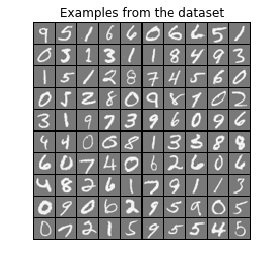

[[ 9  5  1  6  6 10  6  6  5  1]
 [10  3  1  3  1  1  8  4  9  3]
 [ 1  5  1  2  8  7  4  5  6 10]
 [10  5  2  8 10  9  8  1 10  2]
 [ 3  1  9  7  3  9  6 10  9  6]
 [ 4  4 10 10  8  1  3  3  8  8]
 [ 6 10  7  4 10  6  2  6 10  6]
 [ 4  8  2  6  1  7  9  1  1  3]
 [10  9 10  6  2  9  5  9 10  5]
 [10  7  2  1  5  9  5  5  4  5]]


In [12]:
# Setup parameters you will use for this exercise
input_layer_size = 400  # 20x20 input images of digits
hidden_layer_size = 25  # 25 hidden units
num_labels = 10  # 10 labels, from 1 to 10, mapped "0" to label 10

# Loading and Visualizing Data
print("Loading and Visualizing Data ...")
weights = loadmat('data/ex3/ex3weights.mat')  # weights is a 'dict' object

Theta1 = weights["Theta1"]  # Theta1 has shape (25, 401)
Theta2 = weights["Theta2"]  # Theta2 has shape (10, 26)

# Randomly select 100 data points to display
rand_indices = np.random.randint(0, m, 100)
# Plot examples fromt the dataset
displayData(X[rand_indices])
# Display the labels of the examples. "10" denotes "0"
print(y[rand_indices].reshape(10, 10))

### 2.2. Feedforward Propagation and Prediction
Now you will implement feedforward propagation for the neural network. You will need to complete the code in `predict` to return the neural network's prediction.

You should implement the feedforward computation that computes $h_{\theta}(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $(h_{\theta}(x))_k$.

**Implementation Note: ** The matrix $X$ contains the examples in rows. When you complete the code in `predict` function, you will need to add the column of 1's to the matrix. The matrices `Theta1` and `Theta2` contain the parameters for each unit in rows. Specifically, the first row of `Theta1` corresponds to the first hidden unit in the second layer. When you compute $z^{(2)} = \Theta^{(1)} a^{(1)}$, be sure that you index (and if necessary, transpose) $X$ correctly so that you get $a^{(l)}$ as a column vector.

Once you have done, the script will call your `predict` function using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the accuracy is about 97.5%. After that, an interactive sequence will launch displaying images from the training set one at a time, while the console prints out the predicted label for the displayed image.

In [13]:
def predict(Theta1, Theta2, X):
    """
    `p = predict(Theta1, Theta2, X)` outputs the predicted label of X
    given the trained weights of a neural network (Theta1, Theta2)
    """
    
    m = X.shape[0]  # the number of training examples
    num_labels = Theta2.shape[0]  # the number of labels
    
    # Feedforward
    X = np.hstack((np.ones((m, 1)), X))  # add ones to X
    Z1 = np.dot(Theta1, X.T)
    A1 = sigmoid(Z1)
    Z2 = np.dot(Theta2, np.vstack((np.ones((1, A1.shape[1])), A1)))
    A2 = sigmoid(Z2)
    # Get the max value's index for each column of A2
    p = np.argmax(A2, axis=0) + 1
    p = p[True].T  # turn rank one array p to a column vector
    
    return p;

In [14]:
# Predict for neural network with the given weights
pred = predict(Theta1, Theta2, X)
accuracy = np.sum(pred == y) / m * 100
print("Training set accuracy: " + str(accuracy))

Training set accuracy: 97.52


Displaying Example Image


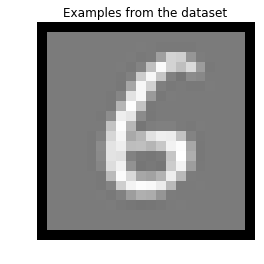

Neural Network Prediction: 6 (digit 6)
Paused - press enter to continue, q to exit: q


In [15]:
# Permulate the data and randomly display one by one
rand_indices = np.random.permutation(m)
for i in rand_indices:
    print("Displaying Example Image")
    displayData(X[[i], :])  # X[[i], :] returns the i-th row vector
    p = np.squeeze(predict(Theta1, Theta2, X[[i], :]))
    print("Neural Network Prediction: " + str(p) \
          + " (digit " + str(p % 10) + ")")
    # Pause with quit option
    s = input("Paused - press enter to continue, q to exit: ")
    if s == 'q':
        break
    else:
        # clear of the output of current cell
        clear_output(wait=True)